<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/kim_nelson_uk_data_24_07_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is replication of Kim&Nelson (1998) with UK data

---
Brief introduction of the code:
This algorithm is a Bayesian model with three main blocks: \
1.Kalman filter\
2.Hamilton(1989) basic filter\
3.Estiamting parameters by multi-move Gibbs sampling.\
We iteratively run the process 1→2→3→1→2→3→1… \
From the algorithm, we can generate:
1. a new economic index of UK
2. recession period of UK
3.In the end, we will also display the distribution of all the parameters.

---

---





In [1]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv'
print('From URL:', url)
kalpre = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv


Firsly, we import the data.\
First three columns are original UK composite leading indicator(CLI), CLI with one lag, CLI with two lags.\
For column 4:8, they are component variables applied to generate original CLI, there were 6 component variables in totoal, but we removed new driver number every year as the data is not suitable for this model without etra modificaions.
Column 9:13,13:18 are component variables with 1 lag and 2 lags individually.
All data have been detrended.

---



---



Then we set intial values for the model. The choice of initial value all follows the seting of Kim \& Nelson (1998).
Initial setting including:

1.   noise matrix for Kalman filter
2.   initial value of all the parameters ψ_ij, λ_i,ϕ_j, σ_i, i=1,2,3,4,5,j=1,2
and p,q which are transition probabilities for this regime-switching model,δ \
detail of this parameters will be introduced later.
3.   iteration times, burn-in period and storage space for the samples
\
In this model, we will run the iteration 10000 times and only draw samples after first 2000 iterations. Frist 2000 iterations are burn-in period which will not be used because values from this part are not stable. According to Kim \& Nelson(1998)'s test, values will stablize after 2000 iterations







In [4]:
#final code

##########################################################################
#          pre-setting
##########################################################################
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings
iter = 10000 # number of iterations
burn = 2000 #we burn the first 2000 iterations and sampling from the later 8000 iterations in the Monter Carlo
scale= StandardScaler()
kalpre = scale.fit_transform(kalpre)#standardize data
np.random.seed(6) #fix randomness
N = kalpre.shape[0] #length of input
Y = np.transpose(kalpre[:,3:9])#Y_{1t} to Y_{5t}
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# Yit-E(Y), remove the mean value
y = np.zeros((5, N))
y1lag = np.zeros((5, N))
y2lag = np.zeros((5, N))
for i in range(5):
    y[i-1, :] = kalpre[:, i + 2] - np.mean(kalpre[:, i + 2])
    y1lag[i-1, :] = kalpre[:, i + 7] - np.mean(kalpre[:, i + 7])
    y2lag[i-1, :] = kalpre[:, i + 12] - np.mean(kalpre[:, i + 12])
x = np.zeros((3, N))#empty matrix to save mean value of xi_t

var_vt=1


Q_kal = np.array([[var_vt, 0, 0],
[0, 0, 0],
[0, 0, 0]])
#Q in kalman filter, process noise, we rename it as Q_kal
# to avoid repeated use of Q in Gibbs sampling
phi=np.zeros(2)
psi=np.zeros((5,2))

x = np.zeros((3, N))#empty matrix to save mean value of xi_t
vct = np.zeros((3, N))#empty matrix to save variance of xi_t



mu_st=np.zeros(N) #this is for kalman filter

######################################################
# The following settings are for estimation of parameters in after hmailton basic filter

#Now we begin to set the initial values of parameters wwe are going to estimate in the algorithm

# As this code is a mixture of three independent code, unavoidabely there are repeated variables
#such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
N=kalpre.shape[0]-2

phi_1 = np.random.normal(0, 1, (N - 4, 1))
phi_2 = np.random.normal(0, 1, (N - 4, 1))
lamda_1 = np.random.normal(0, 1, (N, 1))
#these are just initial settings,
#later on we will draw samples of thses parameters by newly generated mean and variance (or other distribution parameters for other types of distribution)
lamda_2 = np.random.normal(0, 1, (N, 1))
lamda_3 = np.random.normal(0, 1, (N, 1))
lamda_4 = np.random.normal(0, 1, (N, 1))
lamda_5 = np.random.normal(0, 1, (N, 1))
Psi1 = np.random.normal(0, 1, (N - 2, 2))
Psi2 = np.random.normal(0, 1, (N - 2, 2))
Psi3 = np.random.normal(0, 1, (N - 2, 2))
Psi4 = np.random.normal(0, 1, (N - 2, 2))
Psi5 = np.random.normal(0, 1, (N - 2, 2))
rrighta3 = np.zeros((1, N - 2))#this matrix is for calculating distribution of lamda
q = 0.9
p = 0.9

# variance and mean initial set
varlamda1 = 1
varlamda2 = 1
varlamda3 = 1
varlamda4 = 1
varlamda5 = 1
meanlamda1 = 0 #lamda_1~N(meanlamda1,varlamda1)
meanlamda2 = 0
meanlamda3 = 0
meanlamda4 = 0
meanlamda5 = 0
varpsi1 = np.eye(2)
varpsi2 = np.eye(2)
varpsi3 = np.eye(2)
varpsi4 = np.eye(2)
varpsi5 = np.eye(2)
meanpsi1 = np.zeros((2, 1))#psi_1~N(meanpsi1,varpsi1), meanpsi1=np.array([[a],[b]]),varpsii1=np.array([[a1,a2],[b1,b2]])
meanpsi2 = np.zeros((2, 1))
meanpsi3 = np.zeros((2, 1))
meanpsi4 = np.zeros((2, 1))
meanpsi5 = np.zeros((2, 1))
sig1a =  N / 2 #sigma_1~IG(sig1a,sig1b) inverse gamma distribution
sig2a =  N / 2
sig3a =  N / 2
sig4a =  N / 2
sig5a =  N / 2
sig1b = 0
sig2b = 0
sig3b = 0
sig4b = 0
sig5b = 0
X1 = np.zeros((N - 2, 2))
X2 = np.zeros((N - 2, 2))
X3 = np.zeros((N - 2, 2))
X4 = np.zeros((N - 2, 2))
X5 = np.zeros((N - 2, 2))
varphi = np.array([[1, 0], [0,1]])
meanphi = np.array([[0], [0]])
varmu = np.array([[1, 0], [0, 1]])
meanmu = np.array([[0], [0]])
mu0=-2
mu1=2.5
mut = np.zeros(N)#corresponding regime for t=3 to N, this is for estimating parameters

Q = np.zeros((N - 4, 2))
Qstar = np.zeros((N - 4, 2))
fvarphi = np.array([[1, 0], [0, 1]])
# Output
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations
mlamda1 = np.zeros(iter-burn)
mlamda2 = np.zeros(iter-burn)
mlamda3 = np.zeros(iter-burn)
mlamda4 = np.zeros(iter-burn)
mlamda5 = np.zeros(iter-burn)
vlamda1 = np.zeros(iter-burn)
vlamda2 = np.zeros(iter-burn)
vlamda3 = np.zeros(iter-burn)
vlamda4 = np.zeros(iter-burn)
vlamda5 = np.zeros(iter-burn)
bsig1 = np.zeros(iter-burn)
bsig2 = np.zeros(iter-burn)
bsig3 = np.zeros(iter-burn)
bsig4 = np.zeros(iter-burn)
bsig5 = np.zeros(iter-burn)
mpsi11 = np.zeros(iter-burn)
mpsi21 = np.zeros(iter-burn)
mpsi31 = np.zeros(iter-burn)
mpsi41 = np.zeros(iter-burn)
mpsi12 = np.zeros(iter-burn)
mpsi22 = np.zeros(iter-burn)
mpsi32 = np.zeros(iter-burn)
mpsi42 = np.zeros(iter-burn)
mpsi51 = np.zeros(iter-burn)
mpsi52 = np.zeros(iter-burn)
vpsi11 = np.zeros(iter-burn)
vpsi21 = np.zeros(iter-burn)
vpsi31 = np.zeros(iter-burn)
vpsi41 = np.zeros(iter-burn)
vpsi12 = np.zeros(iter-burn)
vpsi22 = np.zeros(iter-burn)
vpsi32 = np.zeros(iter-burn)
vpsi42 = np.zeros(iter-burn)
vpsi51 = np.zeros(iter-burn)
vpsi52 = np.zeros(iter-burn)
mphi1 = np.zeros(iter-burn)
mphi2 = np.zeros(iter-burn)
vphi1 = np.zeros(iter-burn)
vphi2 = np.zeros(iter-burn)
mmu1 = np.zeros(iter-burn)
mmu2 = np.zeros(iter-burn)
vmu1 = np.zeros(iter-burn)
vmu2 = np.zeros(iter-burn)
sig1 = np.array([0.2])
sig2 = np.array([0.2])
sig3 = np.array([0.2])
sig4 = np.array([0.2])
sig5 = np.array([0.2])
transition_prob_p=np.zeros(iter-burn)
transition_prob_q=np.zeros(iter-burn)
delta=np.zeros(iter-burn)
# Initialize the DataFrame with the size of 8x419 with NaNs
inputkal1 = pd.DataFrame(np.nan, index=range(419), columns=range(8))
# Fill the columns 4 to 8 with the data from 'kalpre'
inputkal1.iloc[:,3:8] = (y[:,2:421]).T # 419 values

N=kalpre.shape[0]
##################################  initial St
#St=np.zeros(N) # as we are starting from kalman filter, St for kalman filter is 421
def generate_markov_chain(p, q, initial_state, N):
    # Initialize the Markov Chain
    markov_chain = np.zeros(N)
    markov_chain[0] = initial_state

    for i in range(1, N):
        if markov_chain[i-1] == 1:
            markov_chain[i] = np.random.choice([0, 1], p=[1-p, p])
        else:
            markov_chain[i] = np.random.choice([0, 1], p=[q, 1-q])

    return markov_chain
initial_state = 1  # initial state
St = generate_markov_chain(p, q, initial_state, N)
SSt=St
mu_st = mu0 * np.ones(N) + mu1 * np.ones(N) * St
phimu_st=np.zeros(N)
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = np.array(phimu_st)
phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
Mu_st=np.zeros((3,N))
Mu_st[0,:]=phimu_st

new_delta_ct= np.zeros((N, 1))
delta_y_mean = np.zeros((5,1))
for i in range(5):
    delta_y_mean[i-1,0] = np.mean(kalpre[:, i + 2]) #used in generating delta in appendix 7
E=np.array([1,0,0]) #used in generating delta in appendix 7
sample_ct=np.zeros((N, 1))
regime=np.zeros((N, 1))
e_it=np.zeros((5,N)) # for e_it i=1,2,3,4,5 (it's used when calculating delta)
# Remove warning message of time series from each iteration
def custom_warning_handler(*args, **kwargs):
    pass

warnings.showwarning = custom_warning_handler





#observation noise, variance matrix of [epsilon 1,epsilon 2,epsilon 3,epsilon 4,epsilon 5]
    #R = np.array([[i[0][0] if isinstance(i, np.ndarray) else i for i in row] for row in R])

# variance sig_12345 are updated every iteration


phi[0]=0
phi[1]=0
A = np.array([[phi[0], phi[1], 0],
              [1, 0, 0],
              [0, 1, 0]])
   #np.array([[phi1,phi2,0],
   #          [0,phi1,phi2],
   #          [0,  1,    0]])
   # generate new psi from last iteration
psi=np.zeros((5,2))

lamda1=0.5
lamda2=0.5
lamda3=0.5
lamda4=0.5
lamda5=0.5
# initial setting finishes here

##############################################################################


In [5]:

##############################################################################
#Start iteration here
##############################################################################

for i in range(iter):

# First part of MCMC------- Kalman Filter

##############################

    N=kalpre.shape[0]   # length of data

# Use the parameters from last iteration
# we need new A,R,H

    R = np.array([[sig1.item(), 0, 0, 0, 0],
              [0, sig2.item(), 0, 0, 0],
              [0, 0, sig3.item(), 0, 0],
              [0, 0, 0, sig4.item(), 0],
              [0, 0, 0, 0, sig5.item()]])

    H = np.array([
    [lamda1, -lamda1 * psi[0, 0], -lamda1 * psi[0, 1]],
    [lamda2, -lamda2 * psi[1, 0], -lamda2 * psi[1, 1]],
    [lamda3, -lamda3 * psi[2, 0], -lamda3 * psi[2, 1]],
    [lamda4, -lamda4 * psi[3, 0], -lamda4 * psi[3, 1]],
    [lamda5, -lamda5 * psi[4, 0], -lamda5 * psi[4, 1]]])


#all lamda and psi come from random sampling from last iteration
    H = np.squeeze(H)

    P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
# Construct delta_y* using new psi
    ystar = y.T - psi[:, 0].T* y1lag[0:5, :].T- psi[:, 1].T*y2lag[0:5, :].T
    true5D = ystar.T
#form new mu_st
#    St=SSt
    #mu_st = np.random.normal(meanmu[0], np.sqrt(varmu[0,0]))*np.ones(N) + np.random.normal(meanmu[1], np.sqrt(varmu[1,1]))*np.ones(N) * St
#    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St
#    )
#    phimu_st=np.zeros(N)

#    phimu_st = (np.array(mu_st[2:N])
#            - np.array(mu_st[1:N-1]* phi[0])
#            - np.array(mu_st[0:N-2]* phi[1]))
#    phimu_st = np.array(phimu_st)
#    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
#    phimu_st = np.where(np.abs(phimu_st) > 10, 0, phimu_st)
#    Mu_st=np.zeros((3,N))
#    Mu_st[0,:]=phimu_st
 #   Mu_st[1,1:N]=phimu_st[0:N-1]

#start kalman filter
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        z[:, k] = [true5D[0, k], true5D[1, k], true5D[2, k], true5D[3, k], true5D[4, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(3) - np.dot(K, H)), P)  # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct
      #  vct[1, k] = P[1, 1] we won't use second and third row
       # vct[2, k] = P[2, 2]





###########################################################################
# add t+1 data to information set


    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
    xi = np.zeros((1, N))
    V = np.zeros((1, N))
    for ii in range(N-2):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - phi[0]*x[0, N-ii-2] - phi[1]*x[0, N-ii-3] - phimu_st[N-ii-1]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
        Rt = phi[0]**2*vct[0, N-ii-1]+phi[1]**2*vct[0,N-ii-2]+var_vt
        xi[0, N-ii-2] = x[0, N-ii-2] + (phi[0]*vct[0, N-ii-2]+phi[1]*vct[0,N-ii-3])*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
        V[0, N-ii-2] = vct[0, N-ii-2] - (phi[0]**2 * (vct[0,N-ii-2]**2)+phi[1]**2*(vct[0,N-ii-3]**2)) / Rt
        c = normal(xi[0, N-ii-2], np.sqrt(V[0, N-ii-2]))
    V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1

########################
# generate new delta_ct based on new mean and variance

    for iii in range(0, N):
        new_delta_ct[iii] = np.mean(normal(xi[0,iii], np.sqrt(V[0,iii]),1000)) # new delta_c_t
  #  new_delta_ct=xi[0,:] easier option for new_delta_ct




##############################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter



# Use output from Kalman filter to generate regime probability then generate St
    data= new_delta_ct.flatten()
# Create date range
    date_range = pd.date_range(start='1986-02', end='2021-03', freq='M')
# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)

# Fit the model
    mod = sm.tsa.MarkovRegression(
        df['delta_ct'], k_regimes=2, trend="n", switching_variance=True
)
    res = mod.fit()

    # res.smoothed_marginal_probabilities[1] # recession probability
# Attention: this is time series data
# put it back to normal laterv

# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.smoothed_marginal_probabilities[1] < 0.5).astype(int)
    SSt = St.reset_index(drop=True)#new St
    St=SSt[2:N].to_numpy().reshape(-1,1)# for estimating parameters
    # SSt will be set back to St at the start of next iteration for kalman filter








###########################################################################
# etimating parameters through gibbs sampling

# St is ready, we now prepare kalpre1


########
#pay attention:
# n for code below is 419, for code above is 421, make modefication of this

# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct' from each iteration
    for iiii in range(3):
        inputkal1.iloc[:, iiii] = new_delta_ct[2 - iiii:421 - iiii]  # 419 values


    righta3 = inputkal1.iloc[:, 0].T
    N = inputkal1.shape[0]
   # As this code is a mixture of three independent code, unavoidabely there are repeated variables
   #such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
# Section 1
# form psi(L)*delta_y
    ys1 = (inputkal1.iloc[2:N, 3].values - inputkal1.iloc[1:N-1, 3].values * psi[0, 0] - inputkal1.iloc[0:N-2, 3].values * psi[0,1]).reshape(-1, 1)
    ys2 = (inputkal1.iloc[2:N, 4].values - inputkal1.iloc[1:N-1, 4].values * psi[1, 0] - inputkal1.iloc[0:N-2, 4].values * psi[1,1]).reshape(-1, 1)
    ys3 = (inputkal1.iloc[2:N, 5].values - inputkal1.iloc[1:N-1, 5].values * psi[2, 0] - inputkal1.iloc[0:N-2, 5].values * psi[2,1]).reshape(-1, 1)
    ys4 = (inputkal1.iloc[2:N, 6].values - inputkal1.iloc[1:N-1, 6].values * psi[3, 0] - inputkal1.iloc[0:N-2, 6].values * psi[3,1]).reshape(-1, 1)
    ys5 = (inputkal1.iloc[2:N, 7].values - inputkal1.iloc[1:N-1, 7].values * psi[4, 0] - inputkal1.iloc[0:N-2, 7].values * psi[4,1]).reshape(-1, 1)

# delta C*~
    rrighta1 = (righta3[2:N].values - righta3[1:N-1].values * psi[0, 0] - righta3[0:N-2].values * psi[0,1]).reshape(-1, 1)
    rrighta2 = (righta3[2:N].values - righta3[1:N-1].values * psi[1, 0] - righta3[0:N-2].values * psi[1,1]).reshape(-1, 1)
    rrighta3 = (righta3[2:N].values - righta3[1:N-1].values * psi[2, 0] - righta3[0:N-2].values * psi[2,1]).reshape(-1, 1)
    rrighta4 = (righta3[2:N].values - righta3[1:N-1].values * psi[3, 0] - righta3[0:N-2].values * psi[3,1]).reshape(-1, 1)
    rrighta5 = (righta3[2:N].values - righta3[1:N-1].values * psi[4, 0] - righta3[0:N-2].values * psi[4,1]).reshape(-1, 1)

# posterior distribution of lamda mean

    meanlamda1 = 1 / (rrighta1.T @ rrighta1 / sig1 + 1 / varlamda1) * (meanlamda1 / varlamda1 + rrighta1.T @ ys1 / sig1 )
    meanlamda2 = 1 / (rrighta2.T @ rrighta2 / sig2 + 1 / varlamda2) * (meanlamda2 / varlamda2 + rrighta2.T @ ys2 / sig2 )
    meanlamda3 = 1 / (rrighta3.T @ rrighta3 / sig3 + 1 / varlamda3) * (meanlamda3 / varlamda3 + rrighta3.T @ ys3 / sig3 )
    meanlamda4 = 1 / (rrighta4.T @ rrighta4 / sig4 + 1 / varlamda4) * (meanlamda4 / varlamda4 + rrighta4.T @ ys4 / sig4 )
    meanlamda5 = 1 / (rrighta5.T @ rrighta5 / sig5 + 1 / varlamda5) * (meanlamda5 / varlamda5 + rrighta5.T @ ys5 / sig5 )

# posterior distribution of lamda variance
    varlamda1  = 1 / (rrighta1.T @ rrighta1 / sig1 + 1 / varlamda1)
    varlamda2  = 1 / (rrighta2.T @ rrighta2 / sig2 + 1 / varlamda2)
    varlamda3  = 1 / (rrighta3.T @ rrighta3 / sig3 + 1 / varlamda3)
    varlamda4  = 1 / (rrighta4.T @ rrighta4 / sig4 + 1 / varlamda4)
    varlamda5  = 1 / (rrighta5.T @ rrighta5 / sig5 + 1 / varlamda5)

    if np.isnan(meanlamda1).any():
      meanlamda1=meanlamda2=meanlamda3=meanlamda4=meanlamda5=0
      varlamda1=varlamda2=varlamda3=varlamda4=varlamda5=1

#generate new lamda using new mean & new variance
    lamda1 = np.random.normal(meanlamda1, np.sqrt(varlamda1)).item()
    lamda2 = np.random.normal(meanlamda2, np.sqrt(varlamda2)).item()
    lamda3 = np.random.normal(meanlamda3, np.sqrt(varlamda3)).item()
    lamda4 = np.random.normal(meanlamda4, np.sqrt(varlamda4)).item()
    lamda5 = np.random.normal(meanlamda5, np.sqrt(varlamda5)).item()

# Section 2
# generate new psi
# Form Z and X as shown in the algorithm overview
    Z1 = inputkal1.iloc[:, 3].values - inputkal1.iloc[:, 0].values * lamda1
    Z2 = inputkal1.iloc[:, 4].values - inputkal1.iloc[:, 0].values * lamda2
    Z3 = inputkal1.iloc[:, 5].values - inputkal1.iloc[:, 0].values * lamda3
    Z4 = inputkal1.iloc[:, 6].values - inputkal1.iloc[:, 0].values * lamda4
    Z5 = inputkal1.iloc[:, 7].values - inputkal1.iloc[:, 0].values * lamda5

    X1 = np.column_stack((Z1[1:N - 1], Z1[:N - 2]))
    X2 = np.column_stack((Z2[1:N - 1], Z2[:N - 2]))
    X3 = np.column_stack((Z3[1:N - 1], Z3[:N - 2]))
    X4 = np.column_stack((Z4[1:N - 1], Z4[:N - 2]))
    X5 = np.column_stack((Z5[1:N - 1], Z5[:N - 2]))

    fvarpsi1 = np.linalg.pinv(varpsi1) + X1.T @ X1 / sig1
    fvarpsi2 = np.linalg.pinv(varpsi2) + X2.T @ X2 / sig2
    fvarpsi3 = np.linalg.pinv(varpsi3) + X3.T @ X3 / sig3
    fvarpsi4 = np.linalg.pinv(varpsi4) + X4.T @ X4 / sig4
    fvarpsi5 = np.linalg.pinv(varpsi5) + X5.T @ X5 / sig5
# Check for NaNs
    if np.isnan(fvarpsi1).any() or (np.isnan(fvarpsi1[0,0]*fvarpsi1[1,1]-fvarpsi1[0,1]*fvarpsi1[0,1])):
      fvarpsi1 = np.array([[1,0],[0,1]])
    if np.isnan(fvarpsi2).any() or (np.isnan(fvarpsi2[0,0]*fvarpsi2[1,1]-fvarpsi2[0,1]*fvarpsi2[0,1])):
      fvarpsi2 = np.array([[1,0],[0,1]])
    if np.isnan(fvarpsi3).any() or (np.isnan(fvarpsi3[0,0]*fvarpsi3[1,1]-fvarpsi3[0,1]*fvarpsi3[0,1])):
      fvarpsi3 = np.array([[1,0],[0,1]])
    if np.isnan(fvarpsi4).any() or (np.isnan(fvarpsi4[0,0]*fvarpsi4[1,1]-fvarpsi4[0,1]*fvarpsi4[0,1])):
      fvarpsi4 = np.array([[1,0],[0,1]])
    if np.isnan(fvarpsi5).any() or (np.isnan(fvarpsi5[0,0]*fvarpsi5[1,1]-fvarpsi5[0,1]*fvarpsi5[0,1])):
      fvarpsi5 = np.array([[1,0],[0,1]])

# posterior mean of psi
    meanpsi1 = np.linalg.inv(fvarpsi1) @ (np.linalg.inv(varpsi1) @ meanpsi1 + (X1.T @ Z1[2:N]).reshape(-1, 1) / sig1 )
    meanpsi2 = np.linalg.inv(fvarpsi2) @ (np.linalg.inv(varpsi2) @ meanpsi2 + (X2.T @ Z2[2:N]).reshape(-1, 1) / sig2 )
    meanpsi3 = np.linalg.inv(fvarpsi3) @ (np.linalg.inv(varpsi3) @ meanpsi3 + (X3.T @ Z3[2:N]).reshape(-1, 1) / sig3 )
    meanpsi4 = np.linalg.inv(fvarpsi4) @ (np.linalg.inv(varpsi4) @ meanpsi4 + (X4.T @ Z4[2:N]).reshape(-1, 1) / sig4 )
    meanpsi5 = np.linalg.inv(fvarpsi5) @ (np.linalg.inv(varpsi5) @ meanpsi5 + (X5.T @ Z5[2:N]).reshape(-1, 1) / sig5 )

# postrior variance of psi
    varpsi1  = np.linalg.inv(fvarpsi1)
    varpsi2  = np.linalg.inv(fvarpsi2)
    varpsi3  = np.linalg.inv(fvarpsi3)
    varpsi4  = np.linalg.inv(fvarpsi4)
    varpsi5  = np.linalg.inv(fvarpsi5)

# if NaN shows up, replace with initial setting
    if np.isnan(meanpsi1).any():
      meanpsi1 = np.array([[0],[0]])
      varpsi1 = np.array([[1,0],[0,1]])
    if np.isnan(meanpsi2).any():
       meanpsi2 = np.array([[0],[0]])
       varpsi2 = np.array([[1,0],[0,1]])
    if np.isnan(meanpsi3).any():
      meanpsi3 = np.array([[0],[0]])
      varpsi3 = np.array([[1,0],[0,1]])
    if np.isnan(meanpsi4).any():
      meanpsi4 = np.array([[0],[0]])
      varpsi4 = np.array([[1,0],[0,1]])
    if np.isnan(meanpsi5).any():
      meanpsi5 = np.array([[0],[0]])
      varpsi5 = np.array([[1,0],[0,1]])

   # generate new psi from last iteration
    psi[0,0]=np.random.normal(meanpsi1[0], np.sqrt(varpsi1[0, 0])).item()
    psi[0,1]=np.random.normal(meanpsi1[1], np.sqrt(varpsi1[1, 1])).item()
    psi[1,0]=np.random.normal(meanpsi2[0], np.sqrt(varpsi2[0, 0])).item()
    psi[1,1]=np.random.normal(meanpsi2[1], np.sqrt(varpsi2[1, 1])).item()
    psi[2,0]=np.random.normal(meanpsi3[0], np.sqrt(varpsi3[0, 0])).item()
    psi[2,1]=np.random.normal(meanpsi3[1], np.sqrt(varpsi3[1, 1])).item()
    psi[3,0]=np.random.normal(meanpsi4[0], np.sqrt(varpsi4[0, 0])).item()
    psi[3,1]=np.random.normal(meanpsi4[1], np.sqrt(varpsi4[1, 1])).item()
    psi[4,0]=np.random.normal(meanpsi5[0], np.sqrt(varpsi5[0, 0])).item()
    psi[4,1]=np.random.normal(meanpsi5[1], np.sqrt(varpsi5[1, 1])).item()

# Process of generating sigma_i, i=1,2,3,4,5

    Xx1 = X1 * psi[0,:]
    Xx2 = X2 * psi[1,:]
    Xx3 = X3 * psi[2,:]
    Xx4 = X4 * psi[3,:]
    Xx5 = X5 * psi[4,:]
# sigma~IG(sig1a,sig1b), posterior sig1a=4+N/2 and it's fiexed
# we only needs to calculate posterior sig1b
    sig1b = 4 + 0.5*np.dot(((Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1)).T, (Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1))
    sig2b = 4 + 0.5*np.dot(((Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1)).T, (Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1))
    sig3b = 4 + 0.5*np.dot(((Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1)).T, (Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1))
    sig4b = 4 + 0.5*np.dot(((Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1)).T, (Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1))
    sig5b = 4 + 0.5*np.dot(((Z5[2:N] - Xx5[:, 0] - Xx5[:, 1]).reshape(-1, 1)).T, (Z5[2:N] - Xx5[:, 0] - Xx5[:, 1]).reshape(-1, 1))


# generate mew sigma_i with new sig_{i}b
    sig1 = 1 / np.random.gamma(sig1a, 1/sig1b)#sig_a has been set as. 4+N/2 in the prior, no need to change
    sig2 = 1 / np.random.gamma(sig2a, 1/sig2b)
    sig3 = 1 / np.random.gamma(sig3a, 1/sig3b)
    sig4 = 1 / np.random.gamma(sig4a, 1/sig4b)
    sig5 = 1 / np.random.gamma(sig5a, 1/sig5b)

    if np.isnan(sig1).any():
    # If so, replace all nan values with 0
      sig1=sig2=sig3=sig4=sig5=np.array([[0.2]])


#########################################################
# Section 3
# generate phi

# Form G and Q as shown in the overview of section 3
    G = inputkal1.iloc[4:N, 0] - (mut[4:N]).T
    Q[:, 0] = inputkal1.iloc[3:N-1, 0] - (mut[3:N-1]).T
    Q[:, 1] = inputkal1.iloc[2:N-2, 1] - (mut[2:N-2]).T

    fvarphi = Q.T @ Q + np.linalg.inv(varphi)
#    if np.isnan(fvarphi).any() or (np.isnan(fvarphi[0,0]*fvarphi[1,1]-fvarphi[0,1]*fvarphi[0,1])):
#      fvarphi = np.array([[1,0],[0,1]])
# calculate posterior mean of phi
    meanphi = np.linalg.inv(fvarphi) @ (np.linalg.inv(varphi) @ meanphi + (Q.T @ G).reshape(-1, 1) )
# calculate posterior variance of phi
    varphi  = np.linalg.inv(fvarphi)

    if np.isnan(varphi).any() or np.isnan(meanphi).any():
       varphi = np.array([[1,0],[0,1]])
       meanphi = np.array([[0],[0]])



# sampling new phi
    phi[0]=np.random.normal(meanphi[0], np.sqrt(varphi[0, 0])).item()
    phi[1]=np.random.normal(meanphi[1], np.sqrt(varphi[1, 1])).item()#new phi generated from last iteration


# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = inputkal1.iloc[4:N, 0].values.reshape(-1, 1) - phi[0]* inputkal1.iloc[3:N - 1, 0].values.reshape(-1, 1) - phi[1] * inputkal1.iloc[2:N - 2, 0].values.reshape(-1, 1)
    Qstar = np.zeros((N - 4, 2))
    Qstar[:, 0] = np.ones(N-4)
    Qstar[:, 1] = (St[4:N].flatten()
                   - phi[0]* St[3:N - 1].flatten()
                   - phi[1] * St[2:N - 2].flatten()).reshape(-1,)





#   fvarmu=np.array([[np.linalg.inv(varmu)[0,0],0],[0,np.linalg.inv(varmu)[1,1]]])
# generate posterior mean value of mu
#    fvarmu=np.array([[np.linalg.inv(varmu)[0,0],0],[0,np.linalg.inv(varmu)[1,1]]])
    meanmu = np.linalg.inv(np.linalg.inv(varmu) + Qstar.T @ Qstar) @ (np.linalg.inv(varmu) @ meanmu  + Qstar.T @ Gstar)

# generate posterior variance of mu
    varmu  = np.linalg.inv(np.linalg.inv(varmu) + Qstar.T @ Qstar)

# attention, this distribution for mu_o* and mu_1, so we need to calculate mu_0
# mu_0*=mu_0(1-phi1-phi2)

    mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1 -np.sum(phi))).item()
    mu1=(np.random.normal(meanmu[1], np.sqrt(varmu[1, 1]))).item()
    if np.isnan(mu0).any() or np.isnan(mu1).any() or abs(mu1)>10:
      meanmu=np.array([[0],[0]])
      varmu=np.array([[1,0],[0,1]])
      mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1-np.sum(phi))).item()
      mu1=np.random.normal(meanmu[1], np.sqrt(varmu[1, 1])).item()
    counter=0
    while mu1 <= 0 and counter < 100:
      mu1 = np.random.normal(meanmu[1], np.sqrt(varmu[1, 1])).item()
      counter += 1
    if mu1 <= 0:
      mu1 = 0.5


    mut =( mu0 * np.ones(N)
        + mu1 * np.ones(N) * St.flatten().flatten()
    )

########################################################################
#    To check if there is anything wrong in the iteration
#    if i % 100 == 0:  # if the remainder of i divided by 100 is 0, it means i is a multiple of 100
#      print(meanmu[1],mu0,meanpsi3[0],meanlamda3,varpsi4[1,1],meanphi[1],varphi[0,0] )
########################################################################



########################################################################
# main part of gibbs sampling iteration finishes here
########################################################################






########################################################################
########################################################################
# generate delta
# run kalman filter based on equation 10 and 11 in K&N (1998) to calculate delta
# replace by a kalman filter function funstion
    N=kalpre.shape[0]

    A = np.array([[phi[0], phi[1], 0],
              [1, 0, 0],
              [0, 1, 0]])



    H = np.array([
    [lamda1, 0, 0],
    [lamda2, 0, 0],
    [lamda3, 0, 0],
    [lamda4, 0, 0],
    [lamda5, 0, 0]
])


    H = np.squeeze(H)
    P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
    true5D = Y
#form new mu_st
    St=SSt
    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St
    )
    phimu_st=np.zeros(N)

    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
    phimu_st = np.where(np.abs(phimu_st) > 10, 0, phimu_st)
    Mu_st=np.zeros((3,N))
    Mu_st[0,:]=phimu_st
    e_it = y - xi
    R = np.diag(np.var(e_it, axis=1))

#start kalman filter
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        Hh=np.dot(H, np.dot(P, H.T)) + R
        K = np.dot(P, np.dot(H.T, np.linalg.inv(Hh)))  # Kalman equation 3
        z[:, k] = [true5D[0, k], true5D[1, k], true5D[2, k], true5D[3, k], true5D[4, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(3) - np.dot(K, H)), P)  # Kalman equation 5


#########################################################################
# same value of each iteration after first 2000 iterations
    if i>burn-1:

#########################################################################

#      p_00 = res.params[0]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
#      p_11 = 1-res.params[1]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
#.     generated by Markov switching package in paython, no need to calculate by ourselves
      # delta
      newdelta=np.dot(E,np.dot(np.linalg.inv(K[:,0:3]-np.dot((np.eye(3)-np.dot(K,H)),A)),np.dot(K,delta_y_mean)))


      mlamda1[i - burn] = meanlamda1
      mlamda2[i - burn] = meanlamda2
      mlamda3[i - burn] = meanlamda3
      mlamda4[i - burn] = meanlamda4
      mlamda5[i - burn] = meanlamda5
      vlamda1[i - burn] = varlamda1
      vlamda2[i - burn] = varlamda2
      vlamda3[i - burn] = varlamda3
      vlamda4[i - burn] = varlamda4
      vlamda5[i - burn] = varlamda5
      bsig1[i - burn] = sig1
      bsig2[i - burn] = sig2
      bsig3[i - burn] = sig3
      bsig4[i - burn] = sig4
      bsig5[i - burn] = sig5
      mpsi11[i - burn] = meanpsi1[0, 0]
      mpsi21[i - burn] = meanpsi2[0, 0]
      mpsi31[i - burn] = meanpsi3[0, 0]
      mpsi41[i - burn] = meanpsi4[0, 0]
      mpsi51[i - burn] = meanpsi5[0, 0]
      mpsi12[i - burn] = meanpsi1[1, 0]
      mpsi22[i - burn] = meanpsi2[1, 0]
      mpsi32[i - burn] = meanpsi3[1, 0]
      mpsi42[i - burn] = meanpsi4[1, 0]
      mpsi52[i - burn] = meanpsi5[1, 0]
      vpsi11[i - burn] = varpsi1[0, 0]
      vpsi21[i - burn] = varpsi2[0, 0]
      vpsi31[i - burn] = varpsi3[0, 0]
      vpsi41[i - burn] = varpsi4[0, 0]
      vpsi51[i - burn] = varpsi5[0, 0]
      vpsi12[i - burn] = varpsi1[1, 1]
      vpsi22[i - burn] = varpsi2[1, 1]
      vpsi32[i - burn] = varpsi3[1, 1]
      vpsi42[i - burn] = varpsi4[1, 1]
      vpsi52[i - burn] = varpsi5[1, 1]
      mphi1[i - burn] = meanphi[0, 0]
      mphi2[i - burn] = meanphi[1, 0]
      vphi1[i - burn] = varphi[0, 0]
      vphi2[i - burn] = varphi[1, 1]
      mmu1[i - burn] = meanmu[0, 0]
      mmu2[i - burn] = meanmu[1, 0]
      vmu1[i - burn] = varmu[0, 0]
      vmu2[i - burn] = varmu[1, 1]
      transition_prob_p[i-burn]=1-res.params[1]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      transition_prob_q[i-burn]=res.params[0]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
      delta[i-burn]=newdelta
      sample_ct=sample_ct+new_delta_ct
      regime=regime+res.smoothed_marginal_probabilities[1].values.reshape(-1, 1)#will calculate mean value later

In [6]:
import numpy as np
# after getting mean and variance from 8000 iterations, we take mean of 8000 iterations of mean value and variance value
mmlamda1 = np.mean(mlamda1)
mmlamda2 = np.mean(mlamda2)
mmlamda3 = np.mean(mlamda3)
mmlamda4 = np.mean(mlamda4)
mmlamda5 = np.mean(mlamda5)
vvlamda1 = np.mean(vlamda1)
vvlamda2 = np.mean(vlamda2)
vvlamda3 = np.mean(vlamda3)
vvlamda4 = np.mean(vlamda4)
vvlamda5 = np.mean(vlamda5)
mbsig1 = np.mean(bsig1)
mbsig2 = np.mean(bsig2)
mbsig3 = np.mean(bsig3)
mbsig4 = np.mean(bsig4)
mbsig5 = np.mean(bsig5)
mmpsi11 = np.mean(mpsi11)
mmpsi21 = np.mean(mpsi21)
mmpsi31 = np.mean(mpsi31)
mmpsi41 = np.mean(mpsi41)
mmpsi51 = np.mean(mpsi51)
mmpsi12 = np.mean(mpsi12)
mmpsi22 = np.mean(mpsi22)
mmpsi32 = np.mean(mpsi32)
mmpsi42 = np.mean(mpsi42)
mmpsi52 = np.mean(mpsi52)
vvpsi11 = np.mean(vpsi11)
vvpsi21 = np.mean(vpsi21)
vvpsi31 = np.mean(vpsi31)
vvpsi41 = np.mean(vpsi41)
vvpsi51 = np.mean(vpsi51)
vvpsi12 = np.mean(vpsi12)
vvpsi22 = np.mean(vpsi22)
vvpsi32 = np.mean(vpsi32)
vvpsi42 = np.mean(vpsi42)
vvpsi52 = np.mean(vpsi52)
mmphi1 = np.mean(mphi1)
mmphi2 = np.mean(mphi2)
vvphi1 = np.mean(vphi1)
vvphi2 = np.mean(vphi2)
mmmu1 = np.mean(mmu1)
mmmu2 = np.mean(mmu2)
vvmu1 = np.var(mmu1)# mmu1 saves the samples of mu1, mu1 is generated by Monte Carlo, variance would be sampled
                     # from mu0
vvmu2 = np.mean(vmu2)
sqrt_var_bsig1 = np.sqrt(np.var(bsig1))
sqrt_var_bsig2 = np.sqrt(np.var(bsig2))
sqrt_var_bsig3 = np.sqrt(np.var(bsig3))
sqrt_var_bsig4 = np.sqrt(np.var(bsig4))
sqrt_var_bsig5 = np.sqrt(np.var(bsig5))
#sigma is slightly special as it follows inverse Gamma distribution
#but Kim & Nelson (1998) still provides the mean and SD for sigma
# so what we do here is to calculate mean and variance of 80000 sigma_i for i=1,2,3,4,5 from 8000 iterations
mbsig1=np.mean(bsig1)
mbsig2=np.mean(bsig2)
mbsig3=np.mean(bsig3)
mbsig4=np.mean(bsig4)
mbsig5=np.mean(bsig5)




# transition probabilities p & q

meanp=np.mean(transition_prob_p)
meanq=np.mean(transition_prob_q)
varp=np.var(transition_prob_p)
varq=np.var(transition_prob_q)


#regime
regime=regime/(iter-burn)

#print all results
print("mean of lamda1:", mmlamda1)
print("mean of lamda2:", mmlamda2)
print("mean of lamda3:", mmlamda3)
print("mean of lamda4:", mmlamda4)
print("mean of lamda5:", mmlamda5)
print("stanard deviation of lamda1:", np.sqrt(vvlamda1))
print("stanard deviation of lamda2:", np.sqrt(vvlamda2))
print("stanard deviation of lamda3:", np.sqrt(vvlamda3))
print("stanard deviation of lamda4:", np.sqrt(vvlamda4))
print("stanard deviation of lamda5:", np.sqrt(vvlamda5))
print("mean of psi11:", mmpsi11)
print("mean of psi21:", mmpsi21)
print("mean of psi31:", mmpsi31)
print("mean of psi41:", mmpsi41)
print("mean of psi51:", mmpsi51)
print("mean of psi12:", mmpsi12)
print("mean of psi22:", mmpsi22)
print("mean of psi32:", mmpsi32)
print("mean of psi42:", mmpsi42)
print("mean of psi52:", mmpsi52)
print("stanard deviation of psi11:", np.sqrt(vvpsi11))
print("stanard deviation of psi21:", np.sqrt(vvpsi21))
print("stanard deviation of psi31:", np.sqrt(vvpsi31))
print("stanard deviation of psi41:", np.sqrt(vvpsi41))
print("stanard deviation of psi51:", np.sqrt(vvpsi51))
print("stanard deviation of psi12:", np.sqrt(vvpsi12))
print("stanard deviation of psi22:", np.sqrt(vvpsi22))
print("stanard deviation of psi32:", np.sqrt(vvpsi32))
print("stanard deviation of psi42:", np.sqrt(vvpsi42))
print("stanard deviation of psi52:", np.sqrt(vvpsi52))
print("mean of phi1:", mmphi1)
print("mean of phi2:", mmphi2)
print("stanard deviation of phi1:", np.sqrt(vvphi1))
print("stanard deviation of phi2:", np.sqrt(vvphi2))
print("mean of mu1:", mmmu1)
print("mean of mu2:", mmmu2)
print("stanard deviation of mu1:", np.sqrt(vvmu1))
print("stanard deviation of mu2:", np.sqrt(vvmu2))
print("stanard deviation of sigma1:", sqrt_var_bsig1)
print("stanard deviation of sigma2:", sqrt_var_bsig2)
print("stanard deviation of sigma3:", sqrt_var_bsig3)
print("stanard deviation of sigma4:", sqrt_var_bsig4)
print("stanard deviation of sigma5:", sqrt_var_bsig5)
print("mean of sigma1:", mbsig1)
print("mean of sigma2:", mbsig2)
print("mean of sigma3:", mbsig3)
print("mean of sigma4:", mbsig4)
print("mean of sigma5:", mbsig5)
print("mean of p:", meanp)
print("var of p:", varp)
print("mean of q:", meanq)
print("var of q:", varq)
print("mean of delta:", np.mean(delta))
print("var of delta:", np.var(delta))

mean of lamda1: 0.039454754528593046
mean of lamda2: 0.03163319851539825
mean of lamda3: -0.040594406016425846
mean of lamda4: 0.12955273024364733
mean of lamda5: 0.8016540166494763
stanard deviation of lamda1: 0.0005915690681578678
stanard deviation of lamda2: 0.00017759968084515962
stanard deviation of lamda3: 0.0005704973572999466
stanard deviation of lamda4: 0.0005346811692780604
stanard deviation of lamda5: 0.00029483119168476556
mean of psi11: 0.07615435853029826
mean of psi21: 0.8156261140205491
mean of psi31: 0.49472697741655275
mean of psi41: -0.22106078981994534
mean of psi51: 0.12108957369171446
mean of psi12: 0.03219420571207496
mean of psi22: 0.13852811842364224
mean of psi32: -0.11974196179815667
mean of psi42: -0.2878376220806256
mean of psi52: -0.3680340318374402
stanard deviation of psi11: 0.0006981593830552383
stanard deviation of psi21: 0.0007504743445828882
stanard deviation of psi31: 0.0006954670785259623
stanard deviation of psi41: 0.0006848051922618261
stanard de

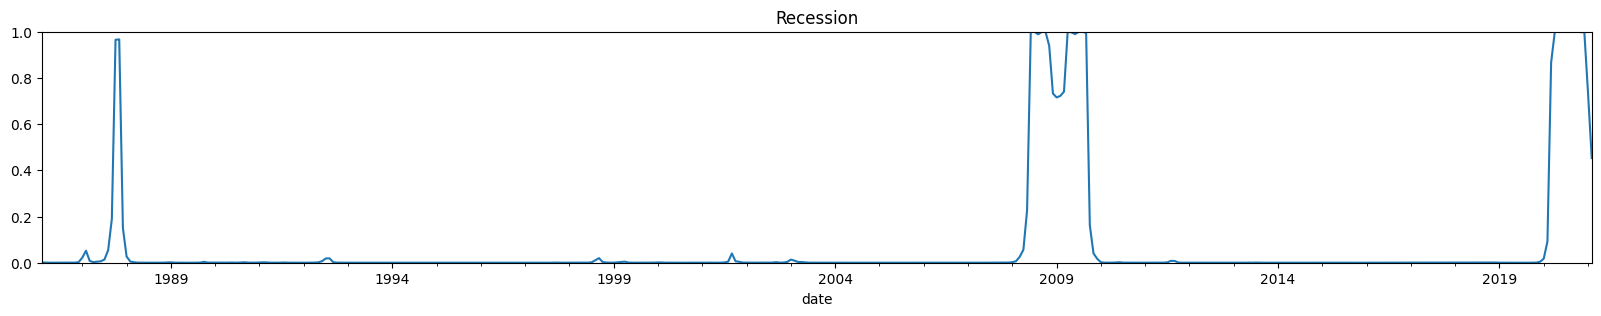

In [7]:
################################################################
####### plot of recession probability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1986-02', end='2021-03', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio': regime.ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series
df_ratios['ratio'].plot(title="Recession", figsize=(20, 3))
plt.ylim(0, 1)
plt.show()

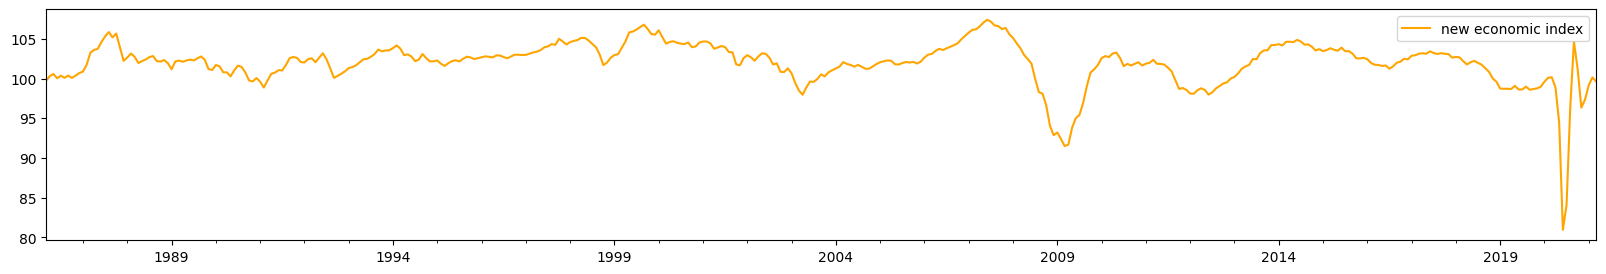

In [8]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=99.72203
newCLI = np.zeros((N, 1))
newCLI[0]=C0+(sample_ct/(iter-burn))[0]
for i in range(1, N):
    newCLI[i] = newCLI[i-1] +  (sample_ct/(iter-burn))[i] # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(20,3), legend=False,label='new economic index',color='orange')


# Set the y-axis limits
#ax.set_ylim(97, 102)
plt.legend()
plt.savefig('myplot.png')
plt.show()

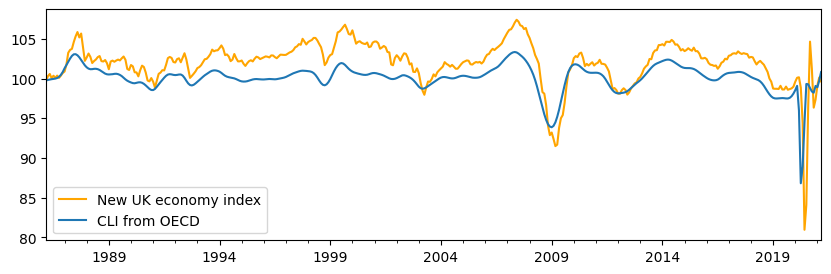

In [9]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/CLI_raw.csv'#original CLI data
CLI = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)
# Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(10,3), legend=False,label='New UK economy index',color='orange')

# Create another pandas Series with the same dates as index
series2 = pd.Series(CLI.values.ravel(), index=dates)
# Plot the series

# Plot the second series
series2.plot(figsize=(10,3), legend=False,label='CLI from OECD')



# Set the y-axis limits
#ax.set_ylim(80, 110)
plt.legend()
plt.savefig('myplot.png')
plt.show()
